In [1]:
# --- Imports and Setup ---

import pandas as pd
import torch
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

# PyKEEN imports
from pykeen.pipeline import pipeline
from pykeen.triples import TriplesFactory
import pykeen.version

# RDFLib for initial graph processing
import rdflib
from rdflib import Graph

print(f"PyKEEN version: {pykeen.version.get_version()}")
print(f"PyTorch version: {torch.__version__}")

# --- Configuration ---
KG_PATH = "../../data/exploitation/knowledge_graph.ttl"
OUTPUT_DIR = Path("../../data/analysis/embeddings")
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
TRIPLES_PATH = OUTPUT_DIR / "kg_triples_for_pykeen.tsv"

/Users/rogerbaigess/Desktop/IA/3r/BDA/large-scale-data-engineering-ai/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


PyKEEN version: 1.11.1
PyTorch version: 2.7.1


In [2]:
# --- Load and Filter Knowledge Graph for KGE Models ---

print(f"Loading full Knowledge Graph from: {KG_PATH}")
g = Graph()
try:
    g.parse(KG_PATH, format="turtle")
    print(f"Graph loaded successfully with {len(g)} triples.")
except FileNotFoundError:
    print(f"ERROR: Knowledge Graph file not found at {KG_PATH}. Please run the exploitation zone script first.")
    raise

# --- Data Preparation for PyKEEN ---
# KGE models like TransE and DistMult work with entity-relation-entity triples.
# We will filter the graph to keep ONLY these structural triples.
# We are completely ignoring triples with literal objects for this training phase.

print("\nFiltering graph to exclude triples with literal objects...")
entity_triples = []
for s, p, o in g:
    # The condition is simple: the subject (s) and object (o) must be URIs (entities).
    # The predicate (p) is always a URI.
    if isinstance(s, rdflib.URIRef) and isinstance(o, rdflib.URIRef):
        entity_triples.append((str(s), str(p), str(o)))

print(f"Filtered down to {len(entity_triples)} entity-relation-entity triples.")

# Save the filtered triples to a TSV file for PyKEEN
print(f"Saving filtered triples to: {TRIPLES_PATH}")
with open(TRIPLES_PATH, "w") as f:
    # Add a header for clarity, though PyKEEN doesn't strictly need it
    # f.write("head\trelation\ttail\n") 
    for s, p, o in entity_triples:
        f.write(f"{s}\t{p}\t{o}\n")

print("Data preparation for PyKEEN complete.")

Loading full Knowledge Graph from: ../../data/exploitation/knowledge_graph.ttl
Graph loaded successfully with 180513 triples.

Filtering graph to exclude triples with literal objects...
Filtered down to 78126 entity-relation-entity triples.
Saving filtered triples to: ../../data/analysis/embeddings/kg_triples_for_pykeen.tsv
Data preparation for PyKEEN complete.


In [ ]:
# --- Create and Split PyKEEN Dataset ---

# Create a TriplesFactory from our TSV file
tf = TriplesFactory.from_path(TRIPLES_PATH, create_inverse_triples=True) # Adding inverse triples can help some models

# Split the data into training, validation, and testing sets
training_set, validation_set, testing_set = tf.split([0.8, 0.1, 0.1], random_state=42)

print("Dataset split successfully:")
print(f"  Training triples:   {training_set.num_triples}")
print(f"  Validation triples: {validation_set.num_triples}")
print(f"  Testing triples:    {testing_set.num_triples}")
print(f"  Total entities:     {tf.num_entities}")
print(f"  Total relations:    {tf.num_relations}")

Dataset split successfully:
  Training triples:   78047
  Validation triples: 39
  Testing triples:    40
  Total entities:     29332
  Total relations:    16


In [3]:
# --- Helper Function for Training and Evaluation ---

def run_kge_pipeline(training, validation, testing, model_name, embedding_dim=100, epochs=100):
    """
    Runs the PyKEEN pipeline for a given model and returns the results.
    """
    print(f"\n{'='*20} Starting Pipeline for {model_name} {'='*20}")
    
    result = pipeline(
        training=training,
        validation=validation,
        testing=testing,
        model=model_name,
        model_kwargs=dict(embedding_dim=embedding_dim),
        training_kwargs=dict(
            num_epochs=epochs,
            batch_size=256,
            use_tqdm_batch=False
        ),
        negative_sampler='basic',
        evaluation_kwargs=dict(batch_size=256),
        stopper='early',
        stopper_kwargs=dict(frequency=5, patience=3, metric='hits@10'),
        random_seed=42,
        device='cpu',
    )
    
    print(f"--- Pipeline for {model_name} complete. ---")
    return result

In [ ]:
# --- Train and Evaluate an Extended Set of Models Across Different Embedding Dimensions ---

# A dictionary to store all pipeline results
results = {}

# --- Configuration for the experiments ---
EPOCHS = 300
BATCH_SIZE = 512

# Define the models and embedding dimensions to test
experiments = {
    'TransE': {'model_name': 'TransE', 'dims': [50, 100, 150]},
    'TransR': {'model_name': 'TransR', 'dims': [100, 150, 200]},
    'TransH': {'model_name': 'TransH', 'dims': [50, 100, 150]},
    'DistMult': {'model_name': 'DistMult', 'dims': [100, 150, 200]},
    'ComplEx': {'model_name': 'ComplEx', 'dims': [100, 150, 200]},
    'RotatE': {'model_name': 'RotatE', 'dims': [100, 150, 200]},
}

# --- Run all experiments ---
for model_key, config in experiments.items():
    for dim in config['dims']:
        # Create a unique key for each experiment run
        experiment_key = f"{model_key}_dim{dim}"
        
        # We store results for each specific run
        results[experiment_key] = run_kge_pipeline(
            training=training_set,
            validation=validation_set,
            testing=testing_set,
            model_name=config['model_name'],
            embedding_dim=dim,
            epochs=EPOCHS
        )
        # Save the model and results for this specific run
        results[experiment_key].save_to_directory(OUTPUT_DIR / f'{experiment_key}_model')

print("\nAll model training experiments are complete.")


==================== Starting Pipeline for TransE ====================


INFO:pykeen.triples.triples_factory:Creating inverse triples.
/Users/rogerbaigess/Desktop/IA/3r/BDA/large-scale-data-engineering-ai/.venv/lib/python3.10/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
Training epochs on cpu: 100%|██████████| 3/3 [00:02<00:00,  1.11epoch/s, loss=0.76, prev_loss=0.842]
Evaluating on cpu:   0%|          | 0.00/40.0 [00:00<?, ?triple/s]WARNING:torch_max_mem.api:Encountered tensors on device_types={'cpu'} while only ['cuda'] are considered safe for automatic memory utilization maximization. This may lead to undocumented crashes (but can be safe, too).
Evaluating on cpu: 100%|██████████| 40.0/40.0 [00:00<00:00, 164triple/s]
INFO:pykeen.evaluation.evaluator:Evaluation took 0.37s seconds
INFO:pykeen.triples.triples_factory:Stored TriplesFactory(num_entities=29332, num_relations=16, create_inverse_triples=True, num

--- Pipeline for TransE complete. ---


INFO:pykeen.pipeline.api:Saved to directory: /Users/rogerbaigess/Desktop/IA/3r/BDA/large-scale-data-engineering-ai/data/analysis/embeddings/TransE_dim8_model
INFO:pykeen.pipeline.api:Using device: cpu
INFO:pykeen.nn.representation:Inferred unique=False for Embedding()
INFO:pykeen.nn.representation:Inferred unique=False for Embedding()
INFO:pykeen.stoppers.early_stopping:Inferred checkpoint path for best model weights: /Users/rogerbaigess/.data/pykeen/checkpoints/best-model-weights-a6661304-f4be-446f-a4d6-429e46dfbe13.pt
INFO:pykeen.triples.triples_factory:Creating inverse triples.
/Users/rogerbaigess/Desktop/IA/3r/BDA/large-scale-data-engineering-ai/.venv/lib/python3.10/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)



==================== Starting Pipeline for TransE ====================


Training epochs on cpu: 100%|██████████| 3/3 [00:04<00:00,  1.54s/epoch, loss=0.635, prev_loss=0.735]
Evaluating on cpu:   0%|          | 0.00/40.0 [00:00<?, ?triple/s]WARNING:torch_max_mem.api:Encountered tensors on device_types={'cpu'} while only ['cuda'] are considered safe for automatic memory utilization maximization. This may lead to undocumented crashes (but can be safe, too).
Evaluating on cpu: 100%|██████████| 40.0/40.0 [00:00<00:00, 114triple/s]
INFO:pykeen.evaluation.evaluator:Evaluation took 0.48s seconds


--- Pipeline for TransE complete. ---


INFO:pykeen.triples.triples_factory:Stored TriplesFactory(num_entities=29332, num_relations=16, create_inverse_triples=True, num_triples=78047, path="/Users/rogerbaigess/Desktop/IA/3r/BDA/large-scale-data-engineering-ai/data/analysis/embeddings/kg_triples_for_pykeen.tsv") to file:///Users/rogerbaigess/Desktop/IA/3r/BDA/large-scale-data-engineering-ai/data/analysis/embeddings/TransE_dim16_model/training_triples
INFO:pykeen.pipeline.api:Saved to directory: /Users/rogerbaigess/Desktop/IA/3r/BDA/large-scale-data-engineering-ai/data/analysis/embeddings/TransE_dim16_model
INFO:pykeen.pipeline.api:Using device: cpu
INFO:pykeen.nn.representation:Inferred unique=False for Embedding()
INFO:pykeen.nn.representation:Inferred unique=False for Embedding(
  (regularizer): LpRegularizer()
)
INFO:pykeen.stoppers.early_stopping:Inferred checkpoint path for best model weights: /Users/rogerbaigess/.data/pykeen/checkpoints/best-model-weights-c26056cf-69d7-430f-861c-13e5f7e002c3.pt
INFO:pykeen.triples.tripl


==================== Starting Pipeline for DistMult ====================


Training epochs on cpu: 100%|██████████| 3/3 [00:03<00:00,  1.15s/epoch, loss=1, prev_loss=1]     
Evaluating on cpu:   0%|          | 0.00/40.0 [00:00<?, ?triple/s]WARNING:torch_max_mem.api:Encountered tensors on device_types={'cpu'} while only ['cuda'] are considered safe for automatic memory utilization maximization. This may lead to undocumented crashes (but can be safe, too).
Evaluating on cpu: 100%|██████████| 40.0/40.0 [00:00<00:00, 547triple/s]
INFO:pykeen.evaluation.evaluator:Evaluation took 0.19s seconds
INFO:pykeen.triples.triples_factory:Stored TriplesFactory(num_entities=29332, num_relations=16, create_inverse_triples=True, num_triples=78047, path="/Users/rogerbaigess/Desktop/IA/3r/BDA/large-scale-data-engineering-ai/data/analysis/embeddings/kg_triples_for_pykeen.tsv") to file:///Users/rogerbaigess/Desktop/IA/3r/BDA/large-scale-data-engineering-ai/data/analysis/embeddings/DistMult_dim8_model/training_triples


--- Pipeline for DistMult complete. ---


INFO:pykeen.pipeline.api:Saved to directory: /Users/rogerbaigess/Desktop/IA/3r/BDA/large-scale-data-engineering-ai/data/analysis/embeddings/DistMult_dim8_model
INFO:pykeen.pipeline.api:Using device: cpu
INFO:pykeen.nn.representation:Inferred unique=False for Embedding()
INFO:pykeen.nn.representation:Inferred unique=False for Embedding(
  (regularizer): LpRegularizer()
)
INFO:pykeen.stoppers.early_stopping:Inferred checkpoint path for best model weights: /Users/rogerbaigess/.data/pykeen/checkpoints/best-model-weights-aee16cd6-c3c5-488a-bf66-9c766df11822.pt
INFO:pykeen.triples.triples_factory:Creating inverse triples.



==================== Starting Pipeline for DistMult ====================


Training epochs on cpu: 100%|██████████| 3/3 [00:05<00:00,  1.74s/epoch, loss=1, prev_loss=1]     
Evaluating on cpu:   0%|          | 0.00/40.0 [00:00<?, ?triple/s]WARNING:torch_max_mem.api:Encountered tensors on device_types={'cpu'} while only ['cuda'] are considered safe for automatic memory utilization maximization. This may lead to undocumented crashes (but can be safe, too).
Evaluating on cpu: 100%|██████████| 40.0/40.0 [00:00<00:00, 396triple/s]
INFO:pykeen.evaluation.evaluator:Evaluation took 0.23s seconds


--- Pipeline for DistMult complete. ---


INFO:pykeen.triples.triples_factory:Stored TriplesFactory(num_entities=29332, num_relations=16, create_inverse_triples=True, num_triples=78047, path="/Users/rogerbaigess/Desktop/IA/3r/BDA/large-scale-data-engineering-ai/data/analysis/embeddings/kg_triples_for_pykeen.tsv") to file:///Users/rogerbaigess/Desktop/IA/3r/BDA/large-scale-data-engineering-ai/data/analysis/embeddings/DistMult_dim16_model/training_triples
INFO:pykeen.pipeline.api:Saved to directory: /Users/rogerbaigess/Desktop/IA/3r/BDA/large-scale-data-engineering-ai/data/analysis/embeddings/DistMult_dim16_model
INFO:pykeen.pipeline.api:Using device: cpu
INFO:pykeen.nn.representation:Inferred unique=False for Embedding(
  (regularizer): LpRegularizer()
)
INFO:pykeen.nn.representation:Inferred unique=False for Embedding(
  (regularizer): LpRegularizer()
)
INFO:pykeen.stoppers.early_stopping:Inferred checkpoint path for best model weights: /Users/rogerbaigess/.data/pykeen/checkpoints/best-model-weights-dac01385-7c45-47dd-8b8b-0d4


==================== Starting Pipeline for ComplEx ====================


Training epochs on cpu: 100%|██████████| 3/3 [00:05<00:00,  1.86s/epoch, loss=1.49, prev_loss=2.04]
Evaluating on cpu:   0%|          | 0.00/40.0 [00:00<?, ?triple/s]WARNING:torch_max_mem.api:Encountered tensors on device_types={'cpu'} while only ['cuda'] are considered safe for automatic memory utilization maximization. This may lead to undocumented crashes (but can be safe, too).
Evaluating on cpu: 100%|██████████| 40.0/40.0 [00:00<00:00, 346triple/s]
INFO:pykeen.evaluation.evaluator:Evaluation took 0.31s seconds


--- Pipeline for ComplEx complete. ---


INFO:pykeen.triples.triples_factory:Stored TriplesFactory(num_entities=29332, num_relations=16, create_inverse_triples=True, num_triples=78047, path="/Users/rogerbaigess/Desktop/IA/3r/BDA/large-scale-data-engineering-ai/data/analysis/embeddings/kg_triples_for_pykeen.tsv") to file:///Users/rogerbaigess/Desktop/IA/3r/BDA/large-scale-data-engineering-ai/data/analysis/embeddings/ComplEx_dim8_model/training_triples
INFO:pykeen.pipeline.api:Saved to directory: /Users/rogerbaigess/Desktop/IA/3r/BDA/large-scale-data-engineering-ai/data/analysis/embeddings/ComplEx_dim8_model
INFO:pykeen.pipeline.api:Using device: cpu
INFO:pykeen.nn.representation:Inferred unique=False for Embedding(
  (regularizer): LpRegularizer()
)
INFO:pykeen.nn.representation:Inferred unique=False for Embedding(
  (regularizer): LpRegularizer()
)
INFO:pykeen.stoppers.early_stopping:Inferred checkpoint path for best model weights: /Users/rogerbaigess/.data/pykeen/checkpoints/best-model-weights-54487cea-da2d-42af-8fa7-10d14b5


==================== Starting Pipeline for ComplEx ====================


Training epochs on cpu: 100%|██████████| 3/3 [00:09<00:00,  3.08s/epoch, loss=2.21, prev_loss=3.09]
Evaluating on cpu:   0%|          | 0.00/40.0 [00:00<?, ?triple/s]WARNING:torch_max_mem.api:Encountered tensors on device_types={'cpu'} while only ['cuda'] are considered safe for automatic memory utilization maximization. This may lead to undocumented crashes (but can be safe, too).
Evaluating on cpu: 100%|██████████| 40.0/40.0 [00:00<00:00, 452triple/s]
INFO:pykeen.evaluation.evaluator:Evaluation took 0.21s seconds


--- Pipeline for ComplEx complete. ---


INFO:pykeen.triples.triples_factory:Stored TriplesFactory(num_entities=29332, num_relations=16, create_inverse_triples=True, num_triples=78047, path="/Users/rogerbaigess/Desktop/IA/3r/BDA/large-scale-data-engineering-ai/data/analysis/embeddings/kg_triples_for_pykeen.tsv") to file:///Users/rogerbaigess/Desktop/IA/3r/BDA/large-scale-data-engineering-ai/data/analysis/embeddings/ComplEx_dim16_model/training_triples
INFO:pykeen.pipeline.api:Saved to directory: /Users/rogerbaigess/Desktop/IA/3r/BDA/large-scale-data-engineering-ai/data/analysis/embeddings/ComplEx_dim16_model
INFO:pykeen.pipeline.api:Using device: cpu
INFO:pykeen.nn.representation:Inferred unique=False for Embedding()
INFO:pykeen.nn.representation:Inferred unique=False for Embedding()
INFO:pykeen.stoppers.early_stopping:Inferred checkpoint path for best model weights: /Users/rogerbaigess/.data/pykeen/checkpoints/best-model-weights-be89f870-dc16-4f7e-bcac-9db78e01125c.pt
INFO:pykeen.triples.triples_factory:Creating inverse trip


==================== Starting Pipeline for RotatE ====================


Training epochs on cpu: 100%|██████████| 3/3 [00:05<00:00,  1.70s/epoch, loss=0.721, prev_loss=0.772]
Evaluating on cpu:   0%|          | 0.00/40.0 [00:00<?, ?triple/s]WARNING:torch_max_mem.api:Encountered tensors on device_types={'cpu'} while only ['cuda'] are considered safe for automatic memory utilization maximization. This may lead to undocumented crashes (but can be safe, too).
Evaluating on cpu: 100%|██████████| 40.0/40.0 [00:00<00:00, 82.2triple/s]
INFO:pykeen.evaluation.evaluator:Evaluation took 0.79s seconds


--- Pipeline for RotatE complete. ---


INFO:pykeen.triples.triples_factory:Stored TriplesFactory(num_entities=29332, num_relations=16, create_inverse_triples=True, num_triples=78047, path="/Users/rogerbaigess/Desktop/IA/3r/BDA/large-scale-data-engineering-ai/data/analysis/embeddings/kg_triples_for_pykeen.tsv") to file:///Users/rogerbaigess/Desktop/IA/3r/BDA/large-scale-data-engineering-ai/data/analysis/embeddings/RotatE_dim8_model/training_triples
INFO:pykeen.pipeline.api:Saved to directory: /Users/rogerbaigess/Desktop/IA/3r/BDA/large-scale-data-engineering-ai/data/analysis/embeddings/RotatE_dim8_model
INFO:pykeen.pipeline.api:Using device: cpu
INFO:pykeen.nn.representation:Inferred unique=False for Embedding()
INFO:pykeen.nn.representation:Inferred unique=False for Embedding()
INFO:pykeen.stoppers.early_stopping:Inferred checkpoint path for best model weights: /Users/rogerbaigess/.data/pykeen/checkpoints/best-model-weights-42a59872-cfe6-4ea4-ae4b-fbdeee6272ba.pt
INFO:pykeen.triples.triples_factory:Creating inverse triples.


==================== Starting Pipeline for RotatE ====================


Training epochs on cpu: 100%|██████████| 3/3 [00:09<00:00,  3.25s/epoch, loss=0.677, prev_loss=0.734]
Evaluating on cpu:   0%|          | 0.00/40.0 [00:00<?, ?triple/s]WARNING:torch_max_mem.api:Encountered tensors on device_types={'cpu'} while only ['cuda'] are considered safe for automatic memory utilization maximization. This may lead to undocumented crashes (but can be safe, too).
Evaluating on cpu: 100%|██████████| 40.0/40.0 [00:00<00:00, 92.9triple/s]
INFO:pykeen.evaluation.evaluator:Evaluation took 0.56s seconds


--- Pipeline for RotatE complete. ---


INFO:pykeen.triples.triples_factory:Stored TriplesFactory(num_entities=29332, num_relations=16, create_inverse_triples=True, num_triples=78047, path="/Users/rogerbaigess/Desktop/IA/3r/BDA/large-scale-data-engineering-ai/data/analysis/embeddings/kg_triples_for_pykeen.tsv") to file:///Users/rogerbaigess/Desktop/IA/3r/BDA/large-scale-data-engineering-ai/data/analysis/embeddings/RotatE_dim16_model/training_triples
INFO:pykeen.pipeline.api:Saved to directory: /Users/rogerbaigess/Desktop/IA/3r/BDA/large-scale-data-engineering-ai/data/analysis/embeddings/RotatE_dim16_model
INFO:pykeen.pipeline.api:Using device: cpu
INFO:pykeen.nn.representation:Inferred unique=False for Embedding()
INFO:pykeen.nn.representation:Inferred unique=False for Embedding()
INFO:pykeen.nn.representation:Inferred unique=False for Embedding()
INFO:pykeen.stoppers.early_stopping:Inferred checkpoint path for best model weights: /Users/rogerbaigess/.data/pykeen/checkpoints/best-model-weights-b7fb58a8-43fa-46ac-af2e-232483e


==================== Starting Pipeline for TransH ====================


Training epochs on cpu: 100%|██████████| 3/3 [00:05<00:00,  1.79s/epoch, loss=0.54, prev_loss=0.641] 
Evaluating on cpu:   0%|          | 0.00/40.0 [00:00<?, ?triple/s]WARNING:torch_max_mem.api:Encountered tensors on device_types={'cpu'} while only ['cuda'] are considered safe for automatic memory utilization maximization. This may lead to undocumented crashes (but can be safe, too).
Evaluating on cpu: 100%|██████████| 40.0/40.0 [00:00<00:00, 395triple/s]
INFO:pykeen.evaluation.evaluator:Evaluation took 0.27s seconds


--- Pipeline for TransH complete. ---


INFO:pykeen.triples.triples_factory:Stored TriplesFactory(num_entities=29332, num_relations=16, create_inverse_triples=True, num_triples=78047, path="/Users/rogerbaigess/Desktop/IA/3r/BDA/large-scale-data-engineering-ai/data/analysis/embeddings/kg_triples_for_pykeen.tsv") to file:///Users/rogerbaigess/Desktop/IA/3r/BDA/large-scale-data-engineering-ai/data/analysis/embeddings/TransH_dim8_model/training_triples
INFO:pykeen.pipeline.api:Saved to directory: /Users/rogerbaigess/Desktop/IA/3r/BDA/large-scale-data-engineering-ai/data/analysis/embeddings/TransH_dim8_model
INFO:pykeen.pipeline.api:Using device: cpu
INFO:pykeen.nn.representation:Inferred unique=False for Embedding()
INFO:pykeen.nn.representation:Inferred unique=False for Embedding()
INFO:pykeen.nn.representation:Inferred unique=False for Embedding()
INFO:pykeen.stoppers.early_stopping:Inferred checkpoint path for best model weights: /Users/rogerbaigess/.data/pykeen/checkpoints/best-model-weights-18c8c135-965a-4673-b00d-baa6033a7


==================== Starting Pipeline for TransH ====================


Training epochs on cpu: 100%|██████████| 3/3 [00:07<00:00,  2.36s/epoch, loss=0.491, prev_loss=0.601]
Evaluating on cpu:   0%|          | 0.00/40.0 [00:00<?, ?triple/s]WARNING:torch_max_mem.api:Encountered tensors on device_types={'cpu'} while only ['cuda'] are considered safe for automatic memory utilization maximization. This may lead to undocumented crashes (but can be safe, too).
Evaluating on cpu: 100%|██████████| 40.0/40.0 [00:00<00:00, 251triple/s]
INFO:pykeen.evaluation.evaluator:Evaluation took 0.28s seconds
INFO:pykeen.triples.triples_factory:Stored TriplesFactory(num_entities=29332, num_relations=16, create_inverse_triples=True, num_triples=78047, path="/Users/rogerbaigess/Desktop/IA/3r/BDA/large-scale-data-engineering-ai/data/analysis/embeddings/kg_triples_for_pykeen.tsv") to file:///Users/rogerbaigess/Desktop/IA/3r/BDA/large-scale-data-engineering-ai/data/analysis/embeddings/TransH_dim16_model/training_triples


--- Pipeline for TransH complete. ---


INFO:pykeen.pipeline.api:Saved to directory: /Users/rogerbaigess/Desktop/IA/3r/BDA/large-scale-data-engineering-ai/data/analysis/embeddings/TransH_dim16_model



All model training experiments are complete.




==================== Final Model Comparison ====================
Metrics evaluated on the testing set (realistic, both sides):
Metric                MRR  Hits@1  Hits@3  Hits@5  Hits@10
Model    Dimension                                        
ComplEx  8         0.0002  0.0000  0.0000  0.0000   0.0000
         16        0.0001  0.0000  0.0000  0.0000   0.0000
DistMult 8         0.0002  0.0000  0.0000  0.0000   0.0000
         16        0.0002  0.0000  0.0000  0.0000   0.0000
RotatE   8         0.0019  0.0000  0.0000  0.0000   0.0000
         16        0.0071  0.0000  0.0125  0.0125   0.0125
TransE   8         0.0024  0.0000  0.0000  0.0000   0.0000
         16        0.0253  0.0000  0.0250  0.0625   0.1000
TransH   8         0.3700  0.3500  0.3875  0.4000   0.4000
         16        0.3951  0.3875  0.4000  0.4000   0.4000

Comparison plot saved to: ../../data/analysis/embeddings/model_comparison_by_dimension.png


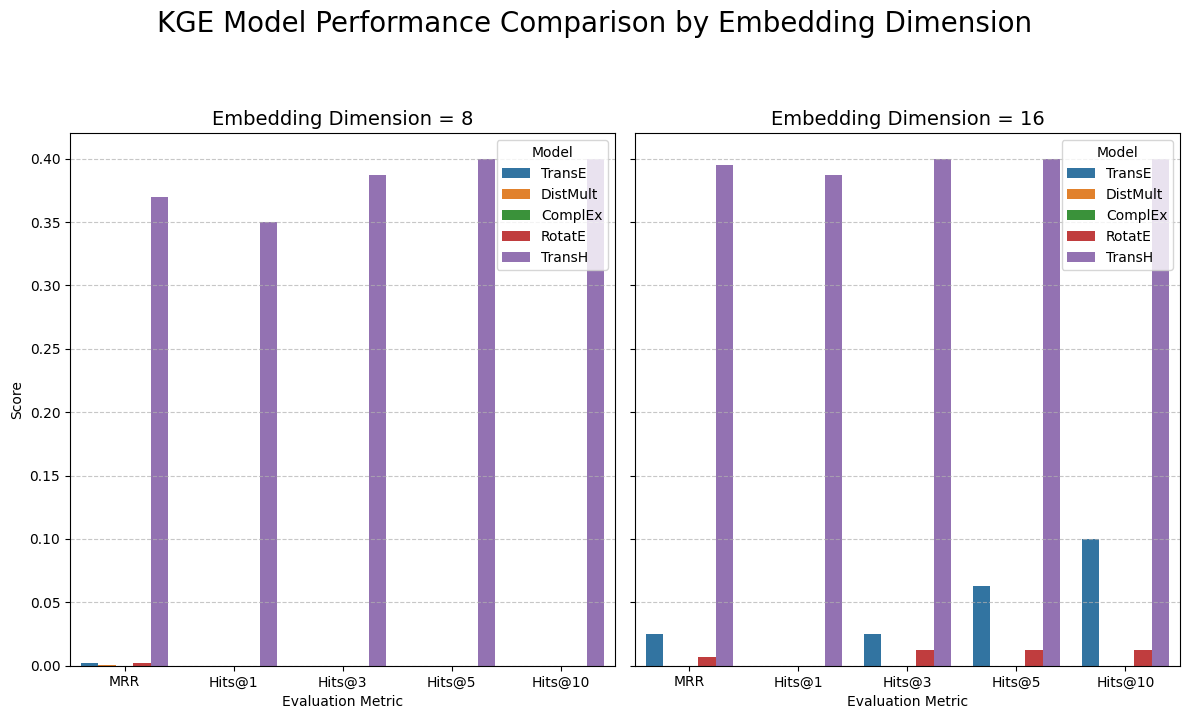

In [5]:
# --- Compare Model Performance Across All Experiments ---

# --- Step 1: Extract and Consolidate Metrics ---
all_metrics_data = []
for experiment_key, result in results.items():
    try:
        metrics_df = result.metric_results.to_df()
        
        # Filter for the final test set results using the correct columns
        test_metrics = metrics_df[
            (metrics_df['Side'] == 'both') &
            (metrics_df['Rank_type'] == 'realistic')
        ].copy()
        
        # Extract model name and dimension from the experiment key
        model_name, dim_str = experiment_key.split('_dim')
        test_metrics['Model'] = model_name
        test_metrics['Dimension'] = int(dim_str)
        
        all_metrics_data.append(test_metrics)
        
    except Exception as e:
        print(f"Warning: Could not process metrics for {experiment_key}. Error: {e}")

if not all_metrics_data:
    print("No model results to display. Check for errors during metric processing.")
else:
    # --- Step 2: Prepare DataFrame for Plotting and Display ---
    results_df = pd.concat(all_metrics_data, ignore_index=True)
    
    # Select only the metrics of interest
    # KEY FIX: Use 'inverse_harmonic_mean_rank' as the MRR equivalent
    final_metric_bases = {
        'inverse_harmonic_mean_rank': 'MRR', # Rename for clarity
        'hits_at_1': 'Hits@1',
        'hits_at_3': 'Hits@3',
        'hits_at_5': 'Hits@5',
        'hits_at_10': 'Hits@10'
    }
    
    # Filter the DataFrame to only include these metrics
    results_filtered = results_df[results_df['Metric'].isin(final_metric_bases.keys())].copy()
    # Apply the clean names
    results_filtered['Metric'] = results_filtered['Metric'].map(final_metric_bases)
    
    # Pivot the table for display
    pivot_df = results_filtered.pivot_table(
        index=['Model', 'Dimension'], 
        columns='Metric', 
        values='Value'
    )
    
    # Reorder columns for logical presentation
    display_order = ['MRR', 'Hits@1', 'Hits@3', 'Hits@5', 'Hits@10']
    pivot_df = pivot_df[display_order]

    print("\n\n" + "="*20 + " Final Model Comparison " + "="*20)
    print("Metrics evaluated on the testing set (realistic, both sides):")
    print(pivot_df.to_string(float_format="%.4f"))

    # --- Step 3: Plotting with Subplots for Each Dimension ---
    
    # Get the unique dimensions that were tested
    dimensions_to_plot = sorted(results_filtered['Dimension'].unique())
    num_dims = len(dimensions_to_plot)
    
    # Create a figure with a subplot for each dimension
    fig, axes = plt.subplots(nrows=1, ncols=num_dims, figsize=(6 * num_dims, 7), sharey=True)
    
    # Handle the case of a single dimension (axes will not be an array)
    if num_dims == 1:
        axes = [axes]

    fig.suptitle('KGE Model Performance Comparison by Embedding Dimension', fontsize=20, y=1.02)
    
    for i, dim in enumerate(dimensions_to_plot):
        ax = axes[i]
        
        # Filter data for the current dimension
        data_for_plot = results_filtered[results_filtered['Dimension'] == dim]
        
        sns.barplot(x='Metric', y='Value', hue='Model', data=data_for_plot, order=display_order, ax=ax)
        
        ax.set_title(f'Embedding Dimension = {dim}', fontsize=14)
        ax.set_xlabel('Evaluation Metric')
        ax.grid(axis='y', linestyle='--', alpha=0.7)
        ax.legend(title='Model')
        
        # Only show Y-axis label on the first plot
        if i == 0:
            ax.set_ylabel('Score')
        else:
            ax.set_ylabel('')

    plt.tight_layout(rect=[0, 0, 1, 0.96]) # Adjust layout to make space for suptitle
    plot_path = OUTPUT_DIR / 'model_comparison_by_dimension.png'
    plt.savefig(plot_path)
    print(f"\nComparison plot saved to: {plot_path}")
    plt.show()